In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

print(pd.__version__)

2.2.1


### List & find out the EMG data directory

In [2]:
import os

# 獲取當前目錄
current_directory = os.getcwd()

# 用於存儲所有 .csv 檔案路徑的列表
csv_files = []

# 遞迴列出所有 .csv 檔案並存儲路徑
for root, dirs, files in os.walk(current_directory):
    for file_name in files:
        if file_name.endswith('.csv'):
            csv_files.append(os.path.join(root, file_name))

print("Total EMG .csv files: ", len(csv_files))

Total EMG .csv files:  51


In [12]:
# define the function to get the selected df
def get_the_selected_df(index, before_range, after_range):
    emg_data_path = csv_files[index]
    file_name = emg_data_path.split('\\')[-1].split('.')[0]
    print("Processing file: ", file_name)

    # loading emg data
    emg_data = pd.read_csv(emg_data_path)

    # 過濾欄位，只保留名稱包含 "EMG" 的欄位以及第一欄位名為 "X[s]" 的欄位
    filtered_columns = [col for col in emg_data.columns if 'EMG' in col or col == 'X[s]']
    # drop last two filtered columns
    filtered_columns = filtered_columns[:-3]
    filtered_columns.append('Trigno sensor 5: Acc 5.X')
    emg_data = emg_data[filtered_columns]

    # 重新命名欄位名稱 1-5 分別為 "EMG 1", "EMG 2", "EMG 3", "EMG 4", "EMG 5-ACC.X"
    emg_data.columns = ['time', 'EMG 1', 'EMG 2', 'EMG 3', 'EMG 4', 'EMG 5']
    emg_data.head()
    
    # 找到 EMG 5 的最大值，並將其標記為 "Peak" 的時間點
    peak_time = emg_data.loc[emg_data['EMG 5'].idxmax()]['time']
    print(f"EMG 5-ACC.X Peak Time: {peak_time:.2f} s")
    peak_value = emg_data['EMG 5'].max()

    # 找到 EMG 5 訊號的最大值時間點的 index
    max_index = emg_data['EMG 5'].idxmax()

    # 計算峰值前後的資料範圍
    start_index = max_index - before_range
    end_index = max_index + after_range

    # 選取資料範圍
    selected_data = emg_data.loc[start_index:end_index]
    
    # 將選取的資料範圍另存成新的 DataFrame
    selected_df = selected_data.copy()
    
    # drop nan values rows by "time" column
    # selected_df_dropna = selected_data.dropna(subset=['time'])
    
    # get the dataframe length
    # df_len = len(selected_df_dropna)
    # print(f"Dataframe length with dropna (time): {df_len}")
    
    # Find global min and max for y-axis scaling
    y_min = min([selected_df[f'EMG {i+1}'].min() for i in range(4)])
    y_max = max([selected_df[f'EMG {i+1}'].max() for i in range(4)])
    
    # Create subplots
    fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f'EMG Signals - {os.path.basename(csv_files[index])}')
    
    # Get EMG 5 peak time for vertical line
    peak_time = selected_df.loc[selected_df['EMG 5'].idxmax(), 'time']
    
    # Plot each EMG signal
    for i in range(5):
        axs[i].plot(selected_df['time'], selected_df[f'EMG {i+1}'], 
                   label=f'EMG {i+1}')
        axs[i].axvline(x=peak_time, color='red', linestyle='--', linewidth=2,
                      label='EMG 5 Peak' if i == 4 else '')
        axs[i].grid(True)
        axs[i].legend(loc='upper right')
        axs[i].set_ylabel('Amplitude')
        if i != 4:
            # Set same y-axis limits for all subplots
            axs[i].set_ylim(y_min, y_max)
    
    
    # Set xlabel only for bottom subplot
    axs[-1].set_xlabel('Time (s)')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f'Time Plot - {file_name}.png', dpi=300, bbox_inches='tight')
    plt.close()

    return selected_df, file_name


### EMG data Processing

In [13]:
# Function to calculate moving RMS
def moving_rms(signal, window_size):
    rms = np.sqrt(pd.Series(signal).rolling(window=window_size).mean()**2)
    rms.index = signal.index  # Ensure the index matches the original signal
    return rms


In [14]:
def data_preprocessing(selected_df, before_range):
    # RMS caculation
    # Get signal data from difference of emg_data
    signal_left_lateral = selected_df['EMG 1']
    signal_left_medial = selected_df['EMG 2']

    signal_right_lateral = selected_df['EMG 4']
    signal_right_medial = selected_df['EMG 3']

    # Define the moving average window size
    N = 25

    # Calculate moving RMS for each channel
    signal_LL_RMS = moving_rms(signal_left_lateral, N)
    signal_LM_RMS = moving_rms(signal_left_medial, N)
    signal_RL_RMS = moving_rms(signal_right_lateral, N)
    signal_RM_RMS = moving_rms(signal_right_medial, N)

    # Drop Nan values
    signal_LL_RMS.dropna(inplace=True)
    signal_LM_RMS.dropna(inplace=True)
    signal_RL_RMS.dropna(inplace=True)
    signal_RM_RMS.dropna(inplace=True)

    # Get signal basic std
    signal_LL_basics_std = signal_LL_RMS.head(before_range).std()
    signal_RL_basics_std = signal_RL_RMS.head(before_range).std()
    
    print(f"signal LL basic Std : {signal_LL_basics_std: .8f}, signal RL basic Std : {signal_RL_basics_std: .8f}")
    
    return signal_LL_RMS, signal_LM_RMS, signal_RL_RMS, signal_RM_RMS, signal_LL_basics_std, signal_RL_basics_std

In [15]:
import matplotlib.pyplot as plt

def emg_plot(event_plot_name, left_std_ratio, left_delta_t, right_std_ratio, right_delta_t):
    """
    Plots a 2D quadrant chart for EMG signal analysis with colored squares indicating the quadrant.

    Parameters:
    std (float): Standard deviation value of the EMG signal.
    delta_t (float): Delta T value of the EMG signal.
    """
    # Create a new figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Determine the quadrant and plot the colored square
    if left_std_ratio > 3 and left_delta_t > 0:
        # First quadrant
        ax.add_patch(plt.Rectangle((2, 2), 5, 5, color='blue', alpha=0.5))
    elif left_std_ratio <= 3 and left_delta_t > 0:
        # Second quadrant
        ax.add_patch(plt.Rectangle((-7, 2), 5, 5, color='blue', alpha=0.5))
    elif left_std_ratio <= 3 and left_delta_t <= 0:
        # Third quadrant
        ax.add_patch(plt.Rectangle((-7, -7), 5, 5, color='blue', alpha=0.5))
    elif left_std_ratio > 3 and left_delta_t <= 0:
        # Fourth quadrant
        ax.add_patch(plt.Rectangle((2, -7), 5, 5, color='blue', alpha=0.5))
        
    # Determine the quadrant and plot the colored square
    if right_std_ratio > 3 and right_delta_t > 0:
        # First quadrant
        ax.add_patch(plt.Rectangle((1.5, 1.5), 5, 5, color='green', alpha=0.5))
    elif right_std_ratio <= 3 and right_delta_t > 0:
        # Second quadrant
        ax.add_patch(plt.Rectangle((-6.5, 1.5), 5, 5, color='green', alpha=0.5))
    elif right_std_ratio <= 3 and right_delta_t <= 0:
        # Third quadrant
        ax.add_patch(plt.Rectangle((-6.5, -6.5), 5, 5, color='green', alpha=0.5))
    elif right_std_ratio > 3 and right_delta_t <= 0:
        # Fourth quadrant
        ax.add_patch(plt.Rectangle((1.5, -6.5), 5, 5, color='green', alpha=0.5))

    # Add horizontal and vertical lines to create quadrants
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axvline(x=0, color='black', linestyle='--')
    
    # Add quadrant labels
    # Add styled text labels with colored box
    def add_styled_text(x, y, text, va='bottom'):
        # Create text box style
        bbox_props = dict(
            boxstyle='round,pad=0.5',
            fc='#1f77b4',      # 背景顏色（白色）
            ec='#1f77b4',   # 邊框顏色（藍色）
            alpha=0.7,      # 背景透明度
            lw=1.5          # 邊框寬度
        )
        
        plt.text(x, y, text,
                horizontalalignment='center',
                verticalalignment=va,
                bbox=bbox_props,
                color='white',
                fontweight='semibold',
                fontsize=9)

    # Add styled quadrant labels
    add_styled_text(4, 0.5, "Exertion + / Coordination -", 'bottom')
    add_styled_text(-4, 0.5, "Exertion - / Coordination -", 'bottom')
    add_styled_text(-4, -0.5, "Exertion - / Coordination +", 'top')
    add_styled_text(4, -0.5, "Exertion + / Coordination +", 'top')

    # Add title and axis labels
    plt.title(f'Muscle Coordination Analysis:\n{event_plot_name}', fontsize=14)
    plt.xlabel('Exertion (Std Ratio > 3)', fontsize=12, fontweight='semibold')
    plt.ylabel('Coordination (Delta T > 0)', fontsize=12, fontweight='semibold')

    # Remove axis numbers and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Set plot legend with color
    plt.legend(['Left Swallowing Muscle', 'Right Swallowing Muscle'], loc='upper left', fontsize=10)

    # Set the limits of the plot
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    
    # Save the plot as a PNG file with high resolution
    plt.savefig(f'{event_plot_name}.png', dpi=300)

    # Display the plot
    plt.show()

In [16]:
# 5000 steps ~= 3.97s, 12000 steps ~= 9.5s
step = 5000
time_peirod = 59.01485 - 55.04427
print(f"step: {step}, time_peirod: {time_peirod}")
timestamp = time_peirod / step
print(f"timestamp: {timestamp}")

step: 5000, time_peirod: 3.9705800000000053
timestamp: 0.0007941160000000011


### Plot the Muscle Coordination Analysis

Processing file:  20241009_Swallowing_Test_1_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 0.01 s
signal LL basic Std :  0.00000167, signal RL basic Std :  0.00000348
left std ratio:  0.958215, right std ratio:  0.749277
LM_max_index:  1.804 sec, LL_max_index:  7.065 sec, left delta t: -5.261 sec
LM_max:  0.02169 (mV), LL_max:  0.00916 (mV)
RM_max_index:  2.868 sec, RL_max_index:  0.314 sec, right delta t:  2.554 sec
RM_max:  4.73035 (mV), RL_max:  0.04404 (mV)


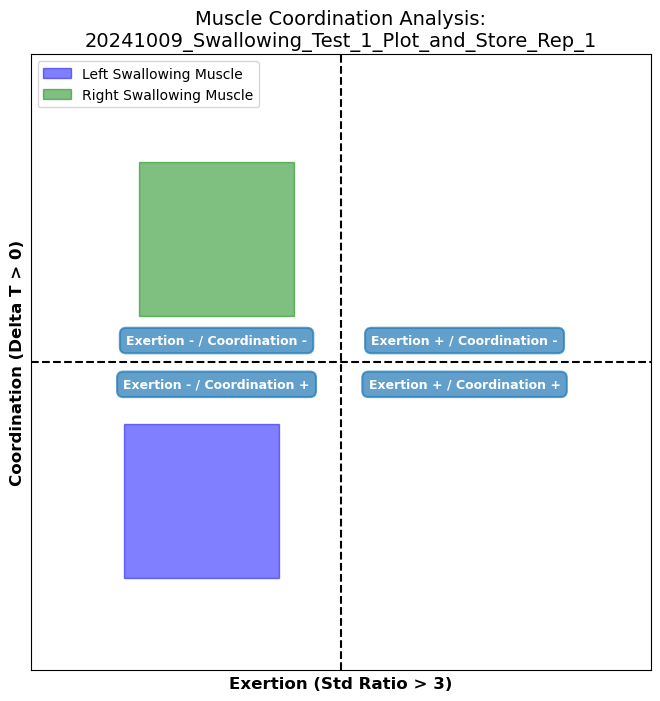

Processing file:  20241009_Swallowing_Test_2_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 4.84 s
signal LL basic Std :  0.00000187, signal RL basic Std :  0.00000236
left std ratio:  1.303206, right std ratio:  1.188140
LM_max_index:  8.048 sec, LL_max_index:  7.390 sec, left delta t:  0.658 sec
LM_max:  0.03131 (mV), LL_max:  0.01366 (mV)
RM_max_index:  11.193 sec, RL_max_index:  13.797 sec, right delta t: -2.604 sec
RM_max:  1.42352 (mV), RL_max:  0.02180 (mV)


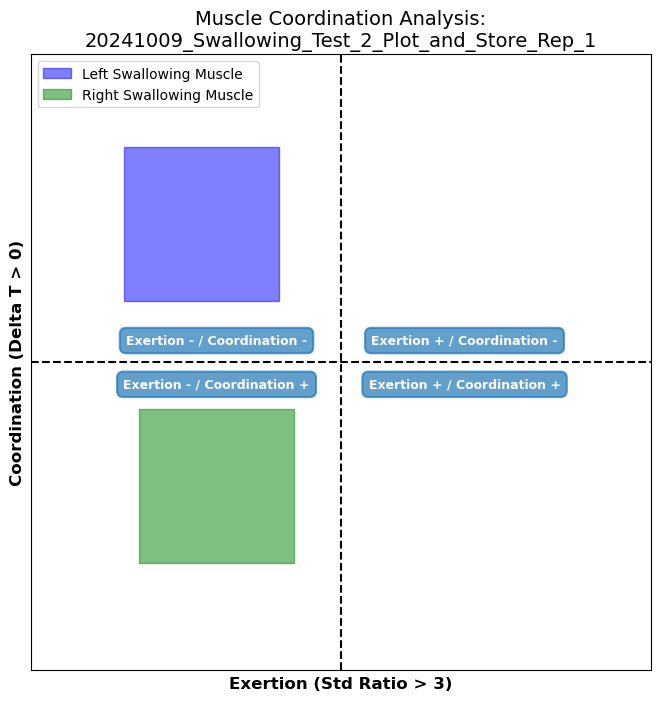

Processing file:  20241009_Swallowing_Test_3_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 3.79 s
signal LL basic Std :  0.00000184, signal RL basic Std :  0.00000252
left std ratio:  1.177365, right std ratio:  1.118342
LM_max_index:  6.925 sec, LL_max_index:  5.854 sec, left delta t:  1.070 sec
LM_max:  0.03760 (mV), LL_max:  0.01766 (mV)
RM_max_index:  7.007 sec, RL_max_index:  8.597 sec, right delta t: -1.590 sec
RM_max:  3.19128 (mV), RL_max:  0.02418 (mV)


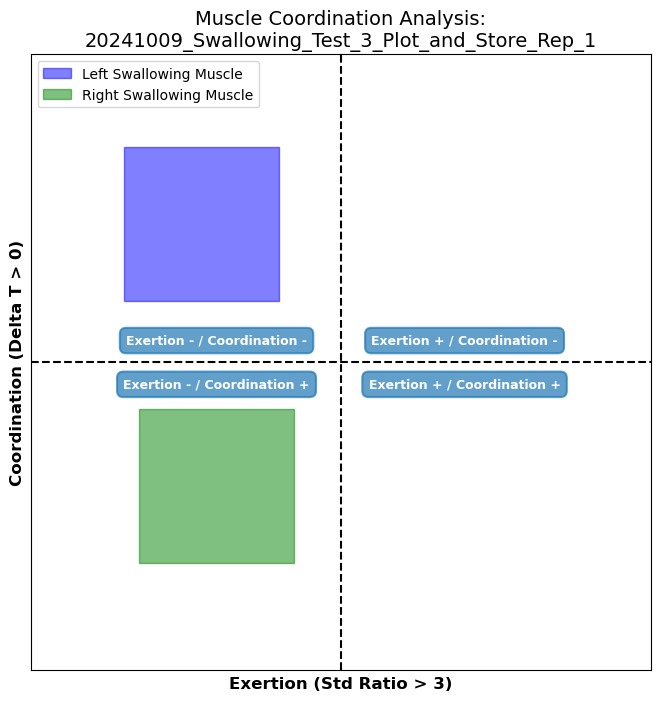

Processing file:  20241009_Swallowing_Test_4_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 4.38 s
signal LL basic Std :  0.00000131, signal RL basic Std :  0.00000227
left std ratio:  1.864791, right std ratio:  1.016238
LM_max_index:  5.387 sec, LL_max_index:  8.422 sec, left delta t: -3.035 sec
LM_max:  0.05046 (mV), LL_max:  0.03618 (mV)
RM_max_index:  5.507 sec, RL_max_index:  10.610 sec, right delta t: -5.103 sec
RM_max:  0.14378 (mV), RL_max:  0.01908 (mV)


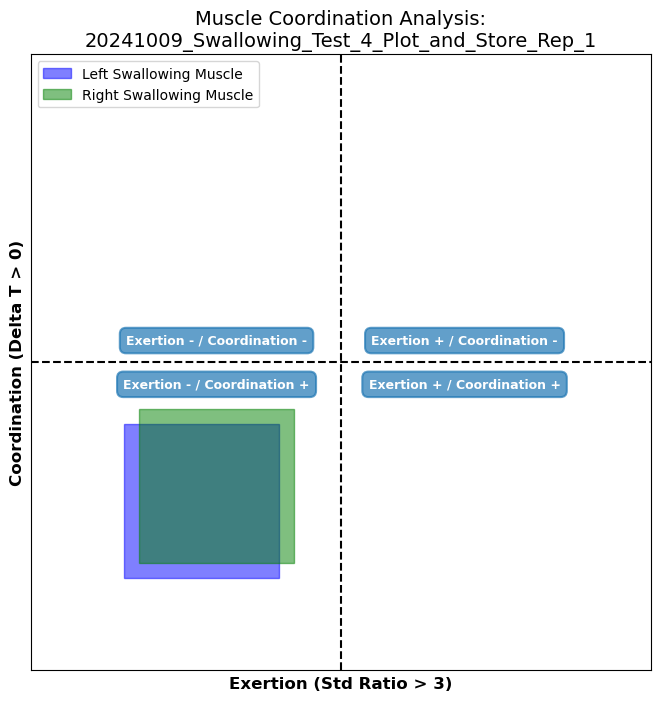

Processing file:  20241009_Swallowing_Test_5_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 2.25 s
signal LL basic Std :  0.00000200, signal RL basic Std :  0.00000232
left std ratio:  1.133512, right std ratio:  1.016534
LM_max_index:  8.735 sec, LL_max_index:  6.914 sec, left delta t:  1.821 sec
LM_max:  0.07800 (mV), LL_max:  0.01417 (mV)
RM_max_index:  4.358 sec, RL_max_index:  4.573 sec, right delta t: -0.215 sec
RM_max:  0.84028 (mV), RL_max:  0.01797 (mV)


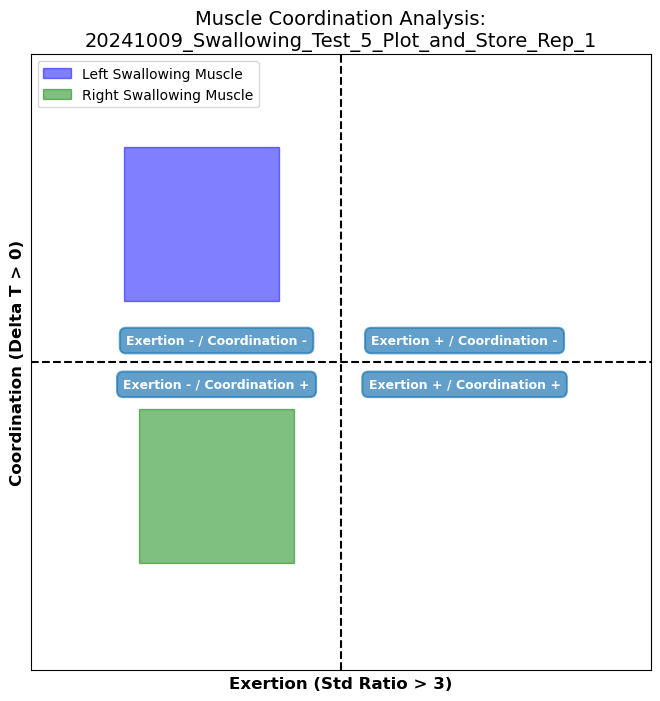

Processing file:  20241009_Swallowing_Test_6_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 6.18 s
signal LL basic Std :  0.00000142, signal RL basic Std :  0.00000175
left std ratio:  2.043530, right std ratio:  2.526745
LM_max_index:  14.615 sec, LL_max_index:  11.963 sec, left delta t:  2.652 sec
LM_max:  0.12172 (mV), LL_max:  0.05555 (mV)
RM_max_index:  14.588 sec, RL_max_index:  10.895 sec, right delta t:  3.693 sec
RM_max:  5.39194 (mV), RL_max:  0.07972 (mV)


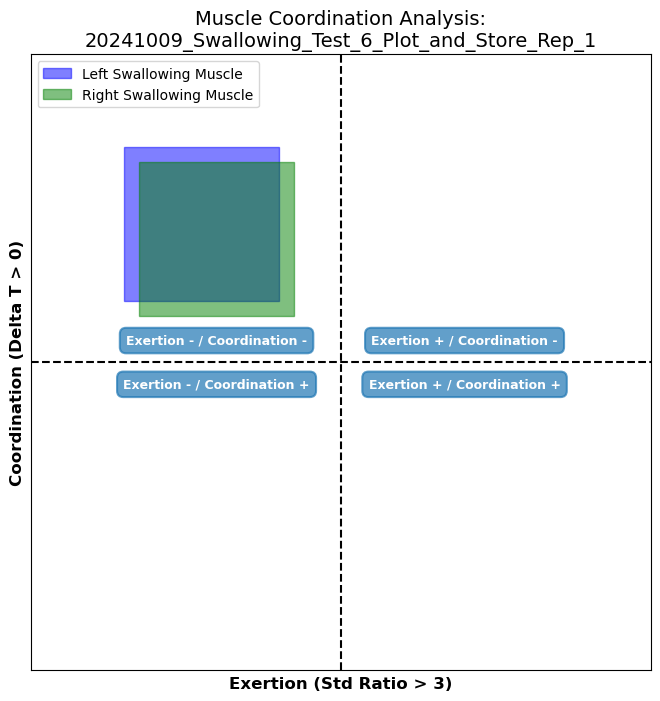

Processing file:  20241009_Swallowing_Test_7_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 2.22 s
signal LL basic Std :  0.00000238, signal RL basic Std :  0.00000331
left std ratio:  1.422894, right std ratio:  3.079689
LM_max_index:  10.401 sec, LL_max_index:  5.086 sec, left delta t:  5.315 sec
LM_max:  0.18956 (mV), LL_max:  0.04236 (mV)
RM_max_index:  2.338 sec, RL_max_index:  5.047 sec, right delta t: -2.709 sec
RM_max:  5.48288 (mV), RL_max:  0.21550 (mV)


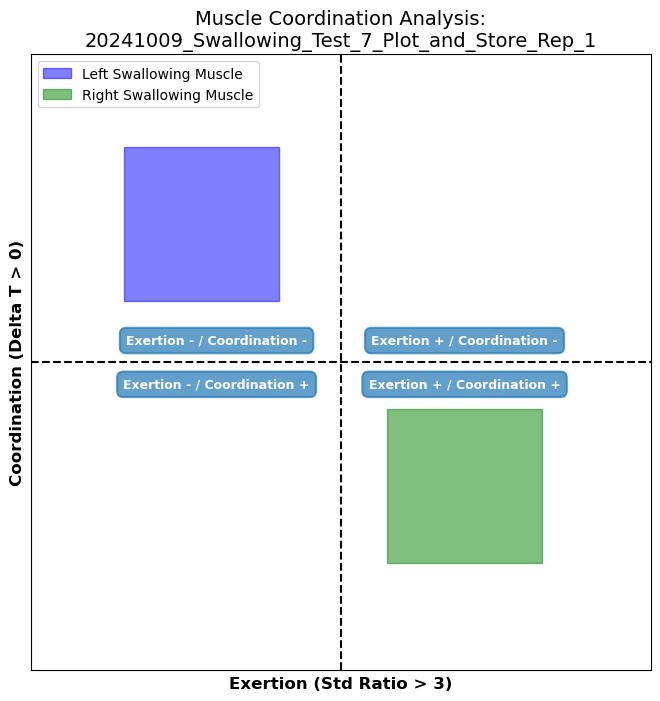

Processing file:  20241016_Swallowing_Test_1_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 0.91 s
signal LL basic Std :  0.00000137, signal RL basic Std :  0.00000341
left std ratio:  0.965152, right std ratio:  0.890056
LM_max_index:  6.614 sec, LL_max_index:  5.247 sec, left delta t:  1.367 sec
LM_max:  0.03875 (mV), LL_max:  0.00779 (mV)
RM_max_index:  6.615 sec, RL_max_index:  2.240 sec, right delta t:  4.375 sec
RM_max:  0.03001 (mV), RL_max:  0.02136 (mV)


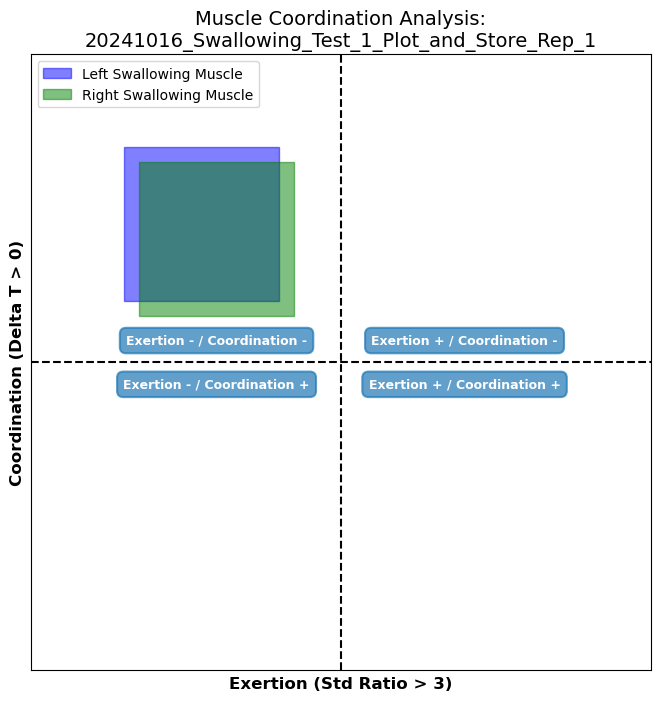

Processing file:  20241016_Swallowing_Test_2_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 5.09 s
signal LL basic Std :  0.00000111, signal RL basic Std :  0.00000198
left std ratio:  1.074070, right std ratio:  1.149601
LM_max_index:  10.515 sec, LL_max_index:  8.508 sec, left delta t:  2.007 sec
LM_max:  0.03530 (mV), LL_max:  0.00775 (mV)
RM_max_index:  10.536 sec, RL_max_index:  11.998 sec, right delta t: -1.462 sec
RM_max:  0.03220 (mV), RL_max:  0.01672 (mV)


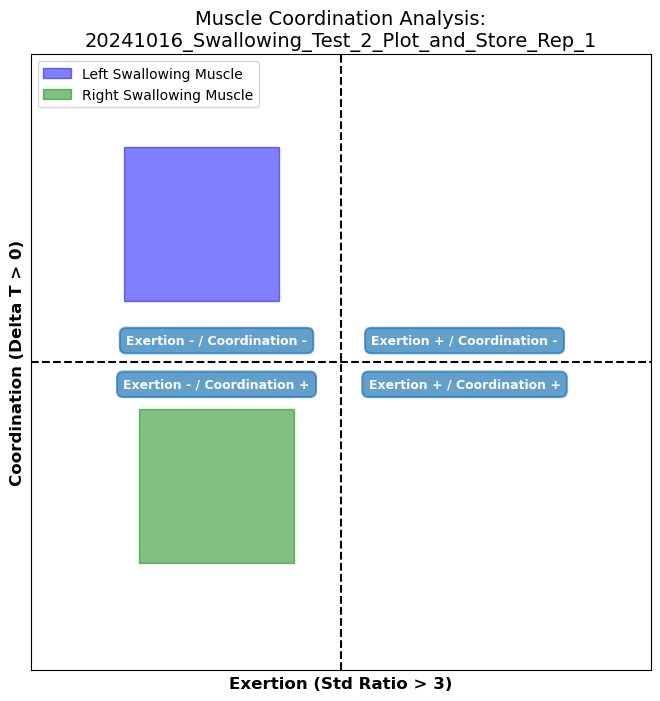

Processing file:  20241016_Swallowing_Test_3_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 5.10 s
signal LL basic Std :  0.00000096, signal RL basic Std :  0.00000202
left std ratio:  1.136575, right std ratio:  0.983239
LM_max_index:  9.834 sec, LL_max_index:  5.778 sec, left delta t:  4.056 sec
LM_max:  0.03298 (mV), LL_max:  0.00671 (mV)
RM_max_index:  9.864 sec, RL_max_index:  8.772 sec, right delta t:  1.092 sec
RM_max:  0.02639 (mV), RL_max:  0.01887 (mV)


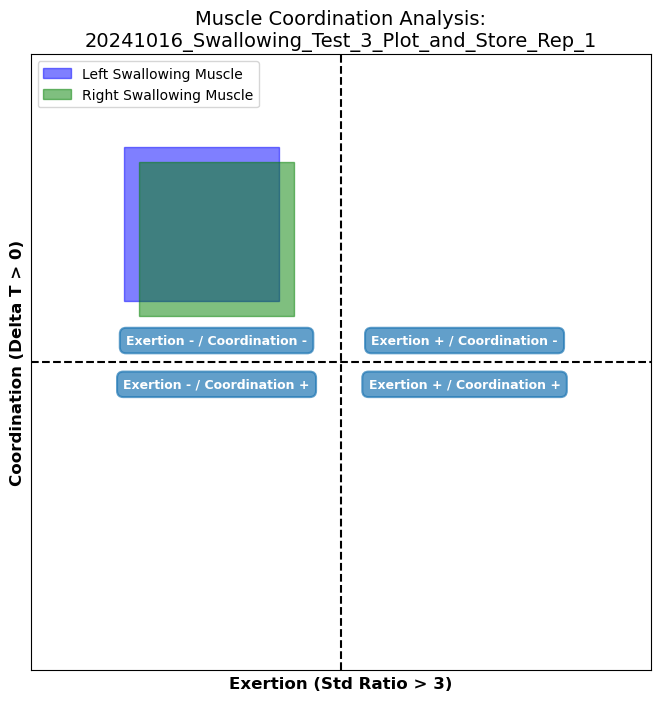

Processing file:  20241016_Swallowing_Test_4_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 4.07 s
signal LL basic Std :  0.00000112, signal RL basic Std :  0.00000248
left std ratio:  0.921044, right std ratio:  0.982027
LM_max_index:  4.729 sec, LL_max_index:  4.857 sec, left delta t: -0.128 sec
LM_max:  0.02688 (mV), LL_max:  0.00734 (mV)
RM_max_index:  11.871 sec, RL_max_index:  4.931 sec, right delta t:  6.940 sec
RM_max:  0.02447 (mV), RL_max:  0.01907 (mV)


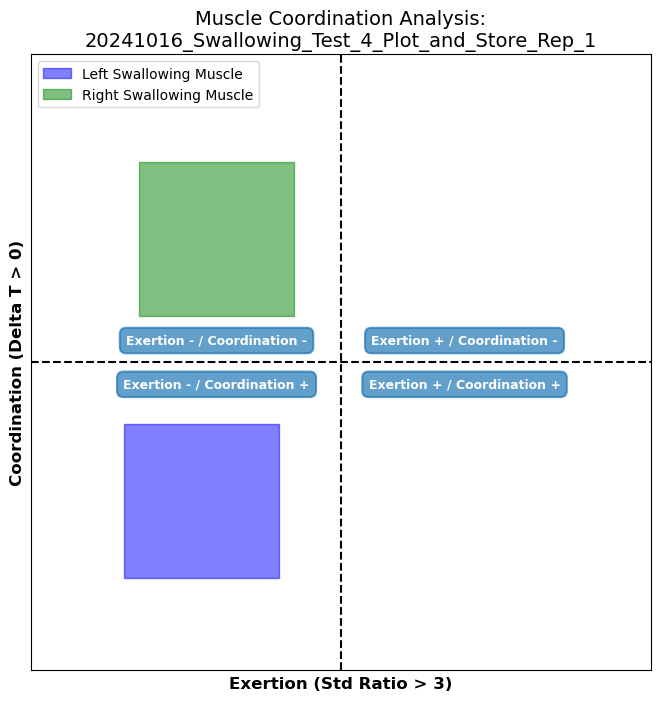

Processing file:  20241016_Swallowing_Test_5_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 5.21 s
signal LL basic Std :  0.00000098, signal RL basic Std :  0.00000247
left std ratio:  1.020063, right std ratio:  0.969556
LM_max_index:  11.584 sec, LL_max_index:  7.203 sec, left delta t:  4.381 sec
LM_max:  0.03672 (mV), LL_max:  0.00657 (mV)
RM_max_index:  11.555 sec, RL_max_index:  6.497 sec, right delta t:  5.059 sec
RM_max:  0.03899 (mV), RL_max:  0.03618 (mV)


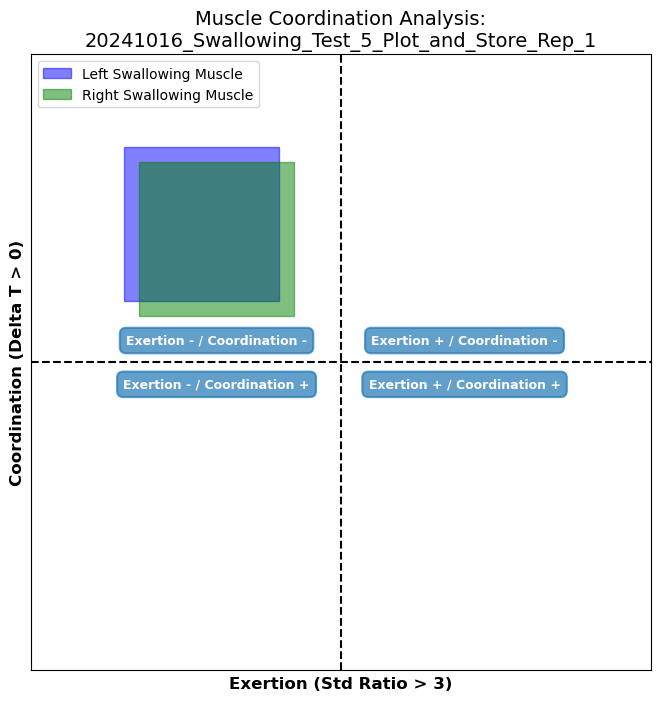

Processing file:  20241016_Swallowing_Test_10_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 3.21 s
signal LL basic Std :  0.00000143, signal RL basic Std :  0.00000220
left std ratio:  1.099810, right std ratio:  1.052110
LM_max_index:  5.300 sec, LL_max_index:  6.934 sec, left delta t: -1.634 sec
LM_max:  0.22098 (mV), LL_max:  0.01300 (mV)
RM_max_index:  5.401 sec, RL_max_index:  4.306 sec, right delta t:  1.095 sec
RM_max:  0.03668 (mV), RL_max:  0.02595 (mV)


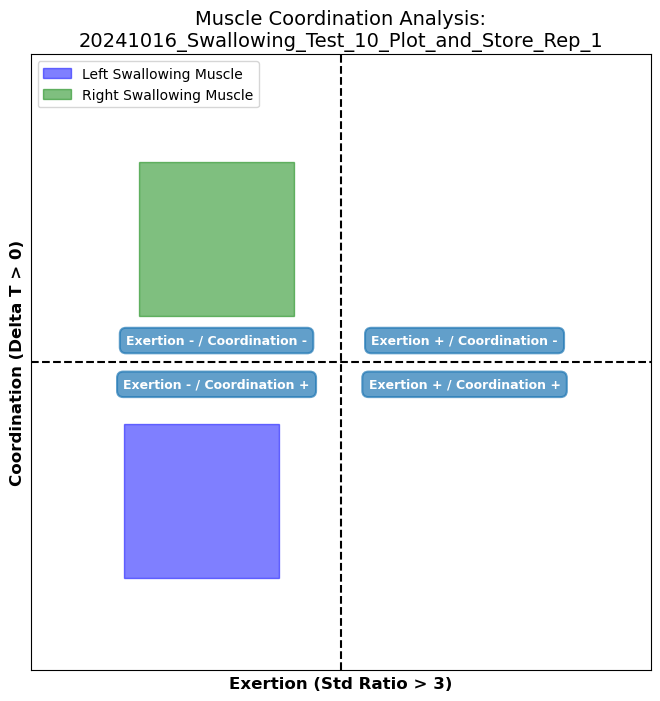

Processing file:  20241016_Swallowing_Test_11_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 9.45 s
signal LL basic Std :  0.00000118, signal RL basic Std :  0.00000163
left std ratio:  1.004528, right std ratio:  0.999852
LM_max_index:  13.504 sec, LL_max_index:  10.598 sec, left delta t:  2.906 sec
LM_max:  0.01683 (mV), LL_max:  0.00715 (mV)
RM_max_index:  15.891 sec, RL_max_index:  12.541 sec, right delta t:  3.350 sec
RM_max:  0.01280 (mV), RL_max:  0.01599 (mV)


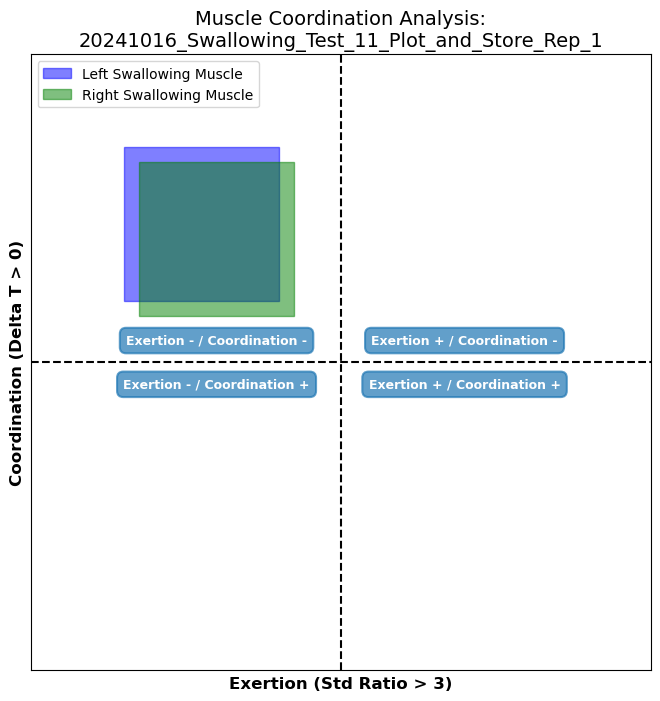

Processing file:  20241016_Swallowing_Test_12_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 2.38 s
signal LL basic Std :  0.00000126, signal RL basic Std :  0.00000202
left std ratio:  0.967356, right std ratio:  0.962619
LM_max_index:  10.934 sec, LL_max_index:  10.796 sec, left delta t:  0.138 sec
LM_max:  0.23270 (mV), LL_max:  0.00804 (mV)
RM_max_index:  10.046 sec, RL_max_index:  10.069 sec, right delta t: -0.023 sec
RM_max:  0.01997 (mV), RL_max:  0.03018 (mV)


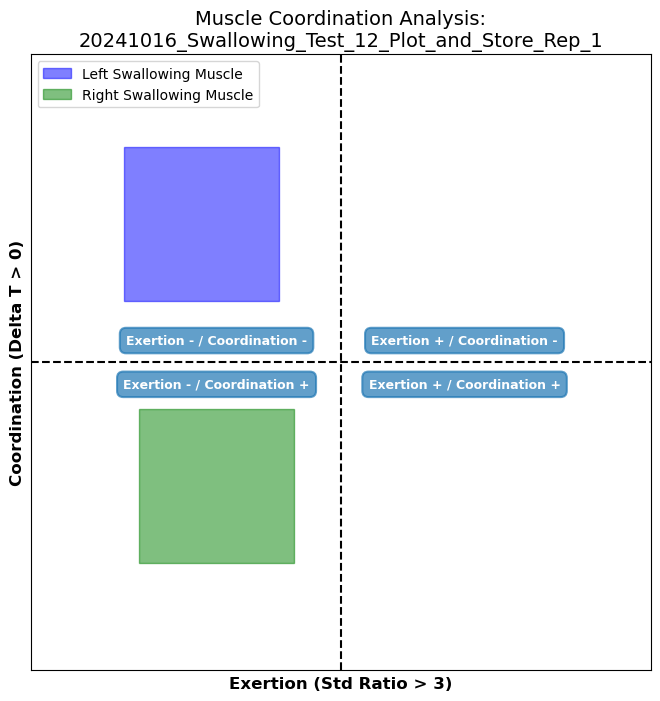

Processing file:  20241016_Swallowing_Test_6_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 0.31 s
signal LL basic Std :  0.00000161, signal RL basic Std :  0.00000470
left std ratio:  0.946287, right std ratio:  0.830343
LM_max_index:  3.772 sec, LL_max_index:  0.657 sec, left delta t:  3.115 sec
LM_max:  0.01629 (mV), LL_max:  0.00843 (mV)
RM_max_index:  3.479 sec, RL_max_index:  0.984 sec, right delta t:  2.495 sec
RM_max:  0.01201 (mV), RL_max:  0.03795 (mV)


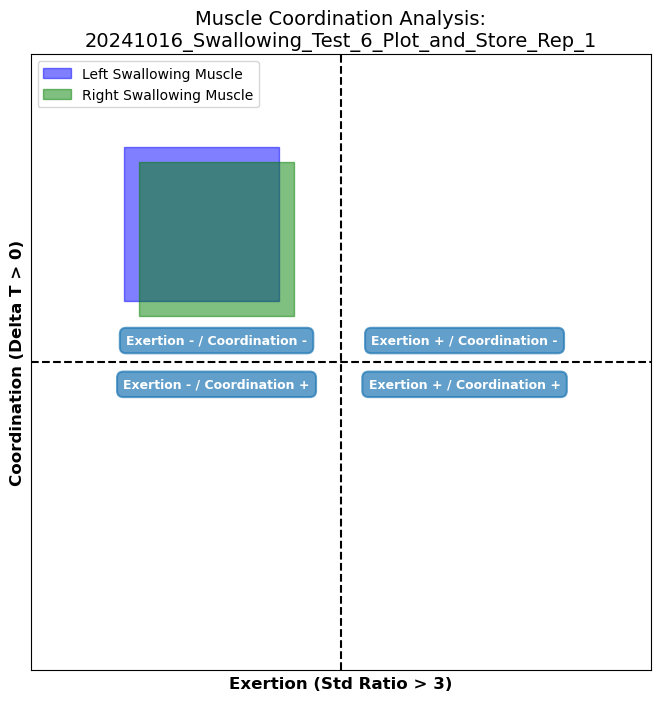

Processing file:  20241016_Swallowing_Test_7_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 4.80 s
signal LL basic Std :  0.00000126, signal RL basic Std :  0.00000242
left std ratio:  1.136331, right std ratio:  0.927700
LM_max_index:  10.303 sec, LL_max_index:  6.648 sec, left delta t:  3.655 sec
LM_max:  0.01315 (mV), LL_max:  0.01126 (mV)
RM_max_index:  11.964 sec, RL_max_index:  6.063 sec, right delta t:  5.901 sec
RM_max:  0.00886 (mV), RL_max:  0.01879 (mV)


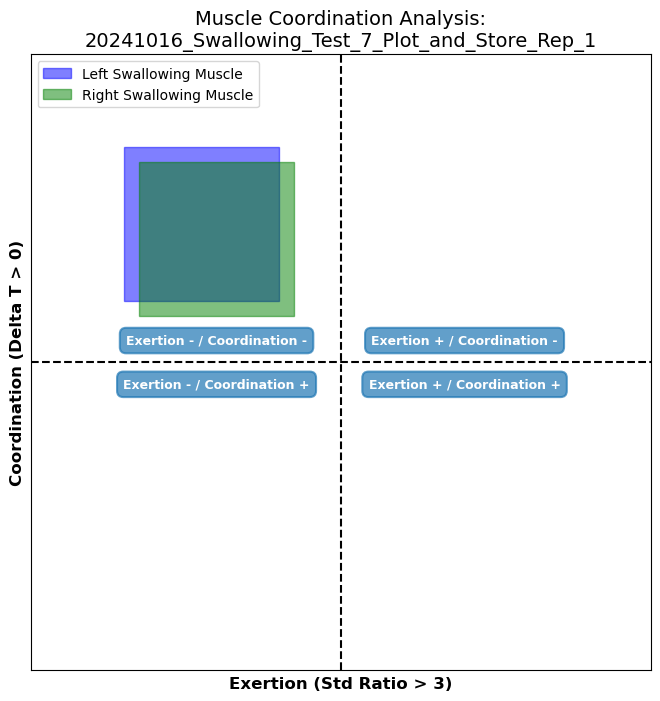

Processing file:  20241016_Swallowing_Test_8_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 8.60 s
signal LL basic Std :  0.00000162, signal RL basic Std :  0.00000228
left std ratio:  0.784766, right std ratio:  1.151079
LM_max_index:  16.387 sec, LL_max_index:  9.090 sec, left delta t:  7.296 sec
LM_max:  0.01554 (mV), LL_max:  0.00850 (mV)
RM_max_index:  11.532 sec, RL_max_index:  12.778 sec, right delta t: -1.246 sec
RM_max:  0.01094 (mV), RL_max:  0.01582 (mV)


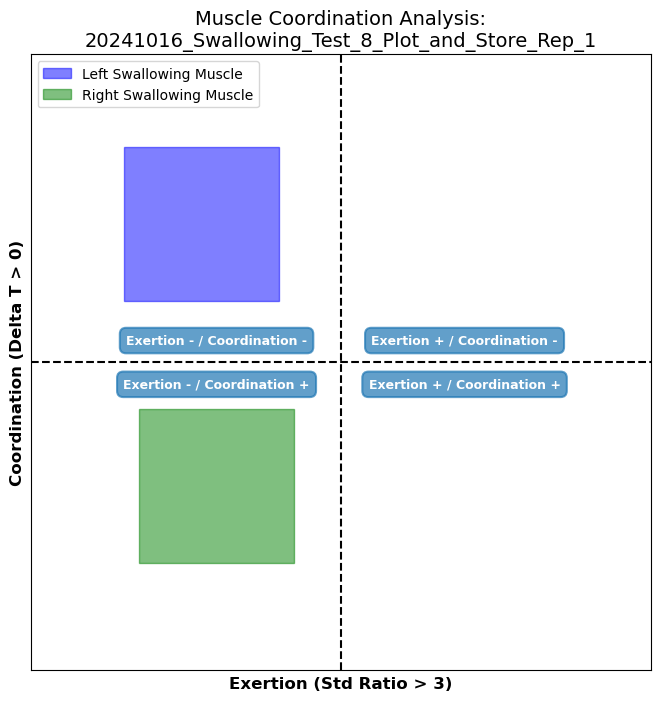

Processing file:  20241016_Swallowing_Test_9_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 2.47 s
signal LL basic Std :  0.00000142, signal RL basic Std :  0.00000252
left std ratio:  0.945054, right std ratio:  0.876822
LM_max_index:  7.763 sec, LL_max_index:  7.945 sec, left delta t: -0.183 sec
LM_max:  0.15042 (mV), LL_max:  0.00950 (mV)
RM_max_index:  7.771 sec, RL_max_index:  7.957 sec, right delta t: -0.186 sec
RM_max:  0.05093 (mV), RL_max:  0.01718 (mV)


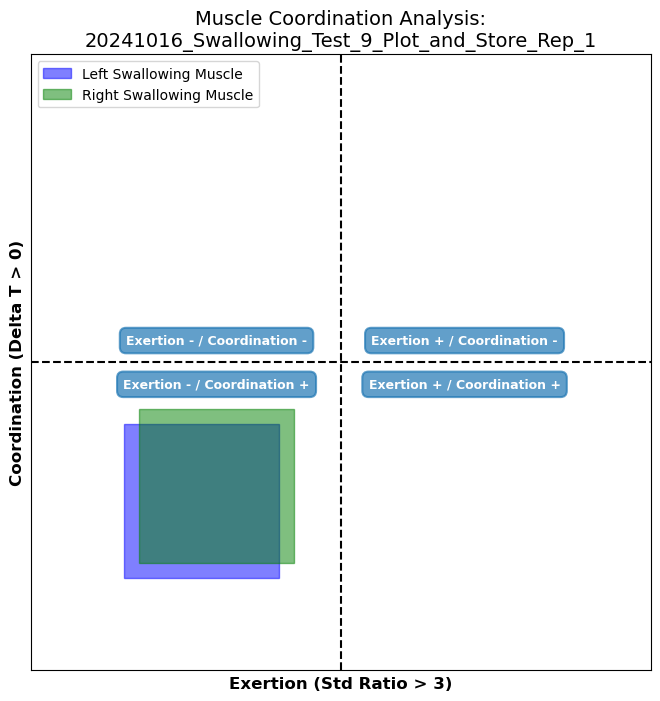

Processing file:  20241016_Swallowing_Test_13_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 1.95 s
signal LL basic Std :  0.00000264, signal RL basic Std :  0.00007831
left std ratio:  0.872086, right std ratio:  0.269404
LM_max_index:  3.715 sec, LL_max_index:  5.267 sec, left delta t: -1.552 sec
LM_max:  5.45987 (mV), LL_max:  0.02691 (mV)
RM_max_index:  3.925 sec, RL_max_index:  2.038 sec, right delta t:  1.888 sec
RM_max:  5.49038 (mV), RL_max:  0.23034 (mV)


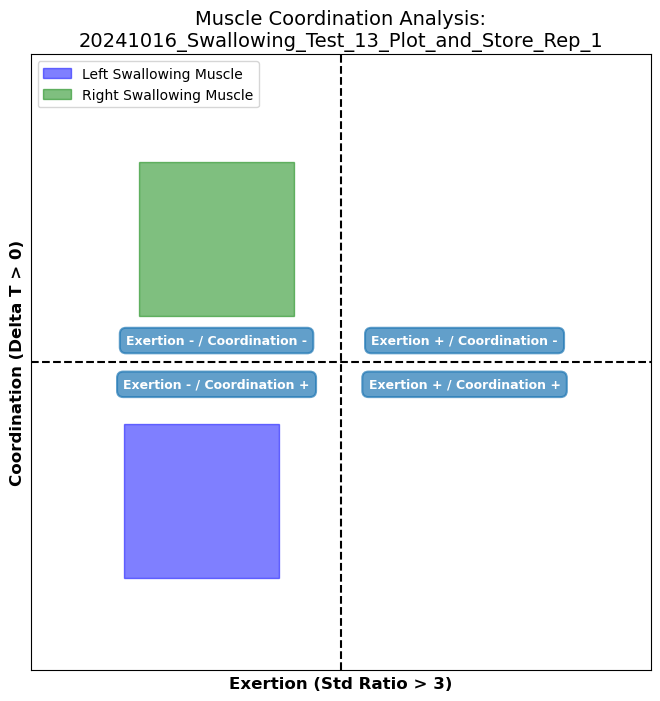

Processing file:  20241016_Swallowing_Test_14_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 3.45 s
signal LL basic Std :  0.00000153, signal RL basic Std :  0.00000189
left std ratio:  0.908017, right std ratio:  1.111343
LM_max_index:  9.133 sec, LL_max_index:  8.474 sec, left delta t:  0.659 sec
LM_max:  1.21656 (mV), LL_max:  0.00927 (mV)
RM_max_index:  5.930 sec, RL_max_index:  5.332 sec, right delta t:  0.598 sec
RM_max:  1.70070 (mV), RL_max:  0.02704 (mV)


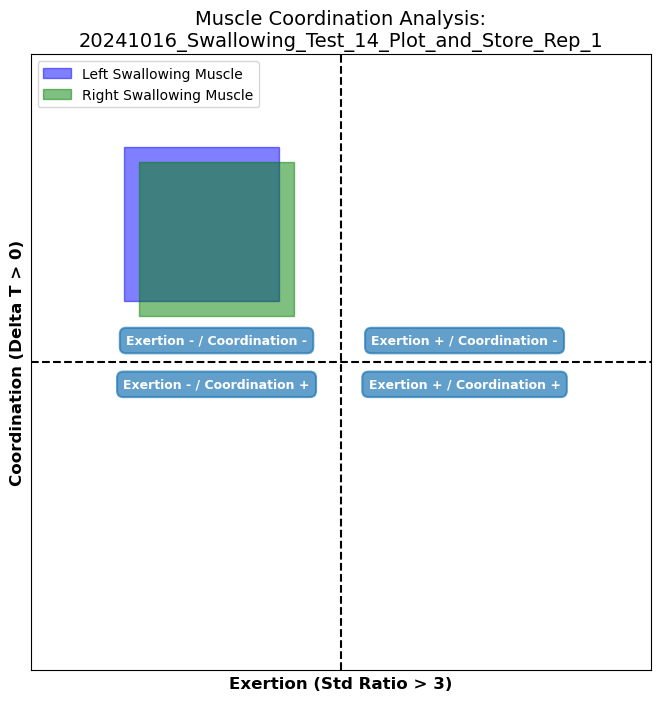

Processing file:  20241016_Swallowing_Test_15_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 2.98 s
signal LL basic Std :  0.00000135, signal RL basic Std :  0.00000177
left std ratio:  0.966871, right std ratio:  1.433121
LM_max_index:  4.251 sec, LL_max_index:  9.518 sec, left delta t: -5.267 sec
LM_max:  0.60428 (mV), LL_max:  0.00911 (mV)
RM_max_index:  4.708 sec, RL_max_index:  10.267 sec, right delta t: -5.559 sec
RM_max:  1.71956 (mV), RL_max:  0.02745 (mV)


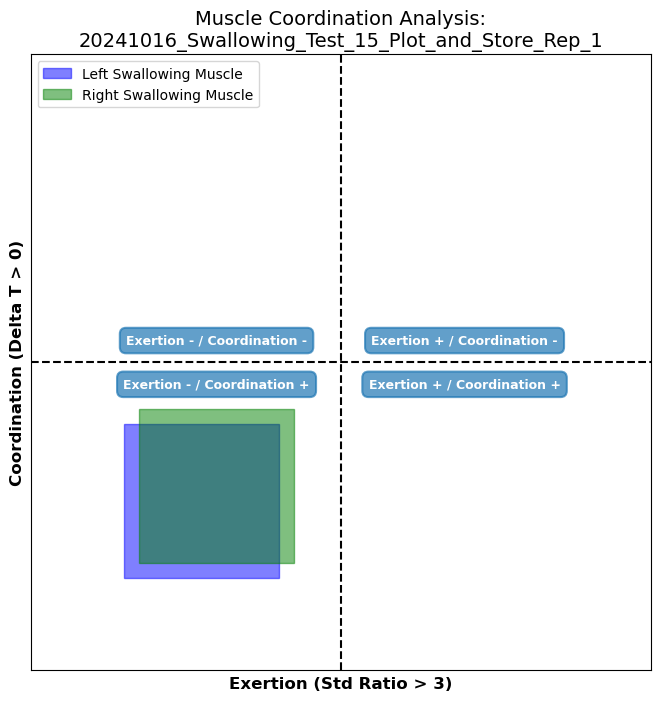

Processing file:  20241016_Swallowing_Test_16_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 2.21 s
signal LL basic Std :  0.00000135, signal RL basic Std :  0.00000200
left std ratio:  0.961667, right std ratio:  1.048849
LM_max_index:  3.556 sec, LL_max_index:  8.612 sec, left delta t: -5.056 sec
LM_max:  0.52871 (mV), LL_max:  0.00941 (mV)
RM_max_index:  8.596 sec, RL_max_index:  8.561 sec, right delta t:  0.035 sec
RM_max:  3.40119 (mV), RL_max:  0.02201 (mV)


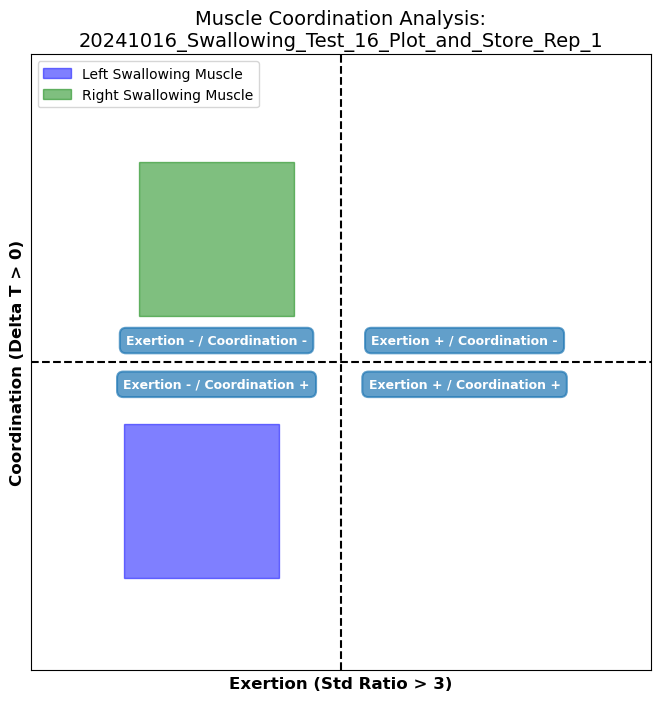

Processing file:  20241016_Swallowing_Test_17_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 0.98 s
signal LL basic Std :  0.00000226, signal RL basic Std :  0.00000147
left std ratio:  1.398067, right std ratio:  0.270825
LM_max_index:  9.425 sec, LL_max_index:  8.401 sec, left delta t:  1.024 sec
LM_max:  5.49137 (mV), LL_max:  0.04341 (mV)
RM_max_index:  8.393 sec, RL_max_index:  8.564 sec, right delta t: -0.171 sec
RM_max:  0.14038 (mV), RL_max:  0.01223 (mV)


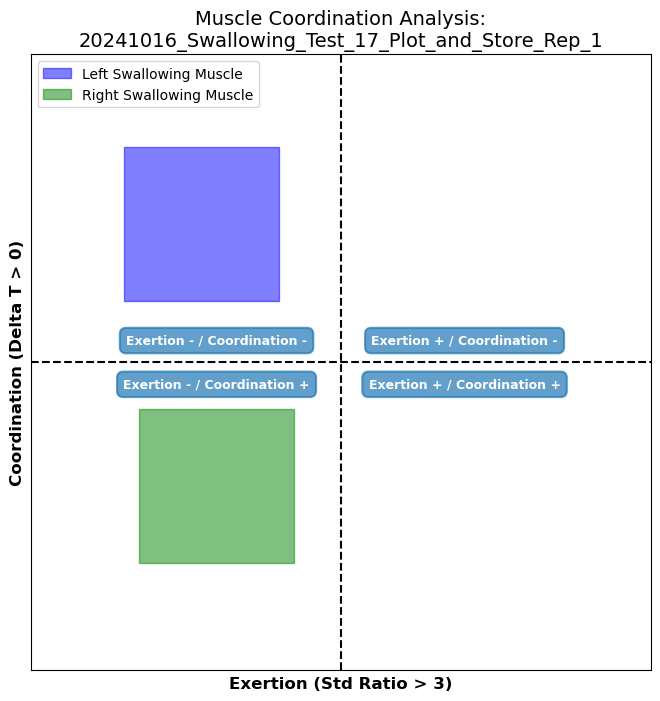

Processing file:  20241016_Swallowing_Test_18_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 3.98 s
signal LL basic Std :  0.00000140, signal RL basic Std :  0.00065635
left std ratio:  1.251692, right std ratio:  0.682186
LM_max_index:  11.915 sec, LL_max_index:  12.348 sec, left delta t: -0.433 sec
LM_max:  5.49035 (mV), LL_max:  0.01293 (mV)
RM_max_index:  11.959 sec, RL_max_index:  11.646 sec, right delta t:  0.314 sec
RM_max:  0.02960 (mV), RL_max:  5.49935 (mV)


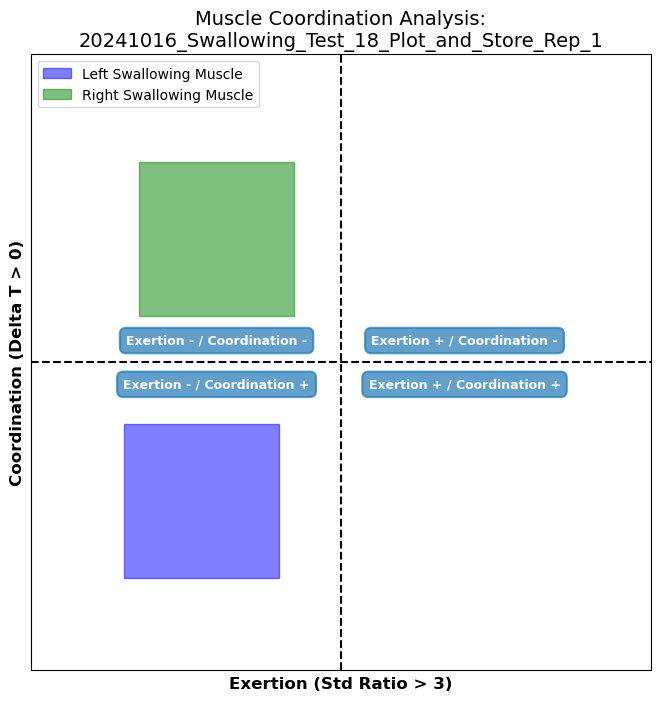

Processing file:  20241016_Swallowing_Test_19_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 5.76 s
signal LL basic Std :  0.00000131, signal RL basic Std :  0.00000029
left std ratio:  1.897659, right std ratio:  2003.983748
LM_max_index:  10.074 sec, LL_max_index:  11.929 sec, left delta t: -1.855 sec
LM_max:  5.49043 (mV), LL_max:  0.02430 (mV)
RM_max_index:  11.597 sec, RL_max_index:  14.544 sec, right delta t: -2.948 sec
RM_max:  0.05312 (mV), RL_max:  5.45790 (mV)


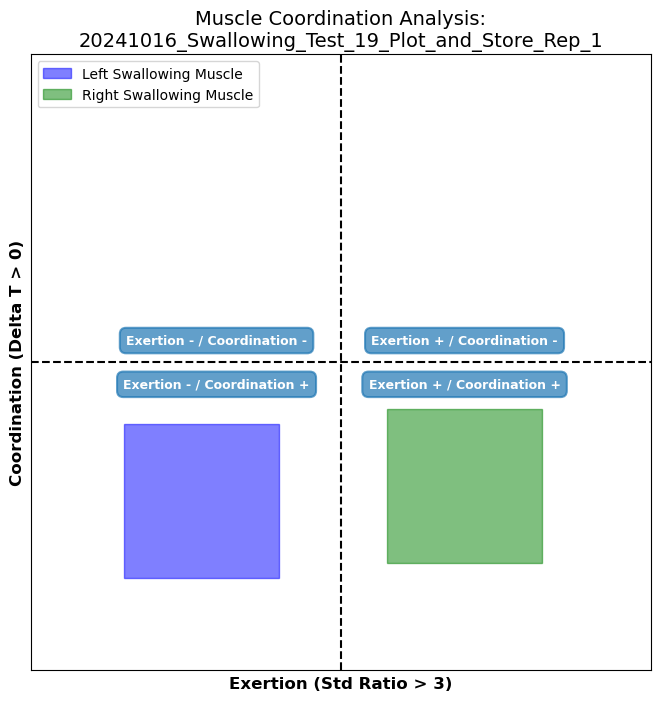

Processing file:  20241016_Swallowing_Test_20_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 4.69 s
signal LL basic Std :  0.00000170, signal RL basic Std :  0.00009808
left std ratio:  0.898011, right std ratio:  4.225359
LM_max_index:  6.378 sec, LL_max_index:  6.335 sec, left delta t:  0.043 sec
LM_max:  0.90391 (mV), LL_max:  0.01312 (mV)
RM_max_index:  6.304 sec, RL_max_index:  6.366 sec, right delta t: -0.061 sec
RM_max:  0.02631 (mV), RL_max:  5.46243 (mV)


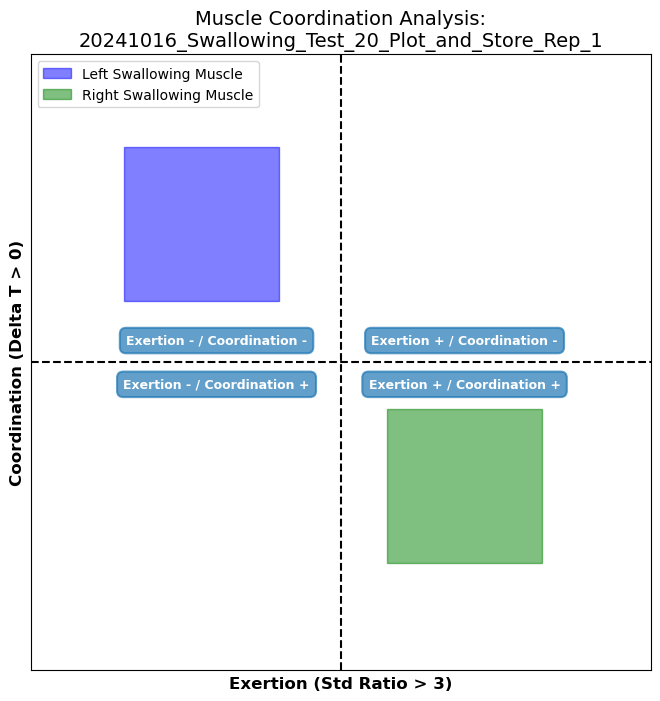

Processing file:  20241016_Swallowing_Test_21_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 2.33 s
signal LL basic Std :  0.00000183, signal RL basic Std :  0.00056749
left std ratio:  1.175511, right std ratio:  0.884903
LM_max_index:  8.450 sec, LL_max_index:  4.363 sec, left delta t:  4.087 sec
LM_max:  5.41037 (mV), LL_max:  0.01764 (mV)
RM_max_index:  11.625 sec, RL_max_index:  11.646 sec, right delta t: -0.021 sec
RM_max:  0.02413 (mV), RL_max:  5.49081 (mV)


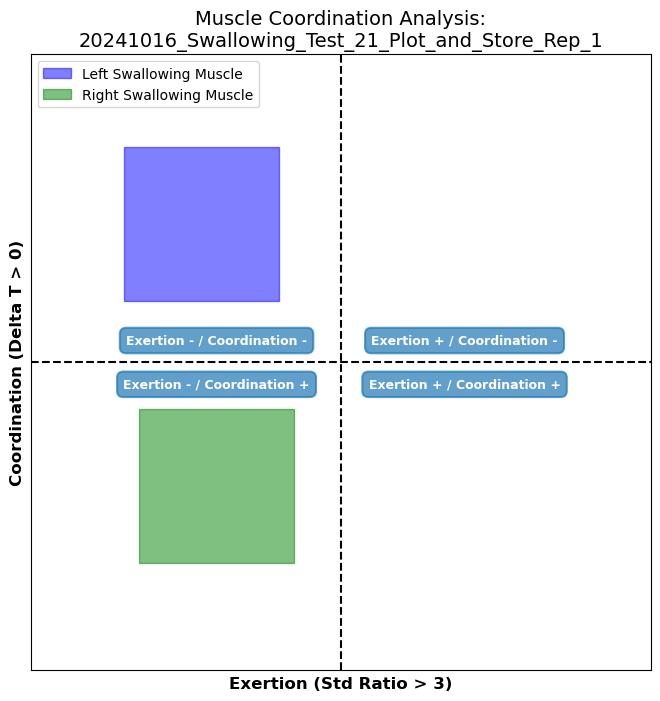

Processing file:  20241023_Swallowing_Test_1_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 1.01 s
signal LL basic Std :  0.00000140, signal RL basic Std :  0.00001129
left std ratio:  0.847648, right std ratio:  0.922733
LM_max_index:  1.536 sec, LL_max_index:  1.692 sec, left delta t: -0.156 sec
LM_max:  0.07898 (mV), LL_max:  0.00754 (mV)
RM_max_index:  1.594 sec, RL_max_index:  1.616 sec, right delta t: -0.022 sec
RM_max:  4.17734 (mV), RL_max:  0.06632 (mV)


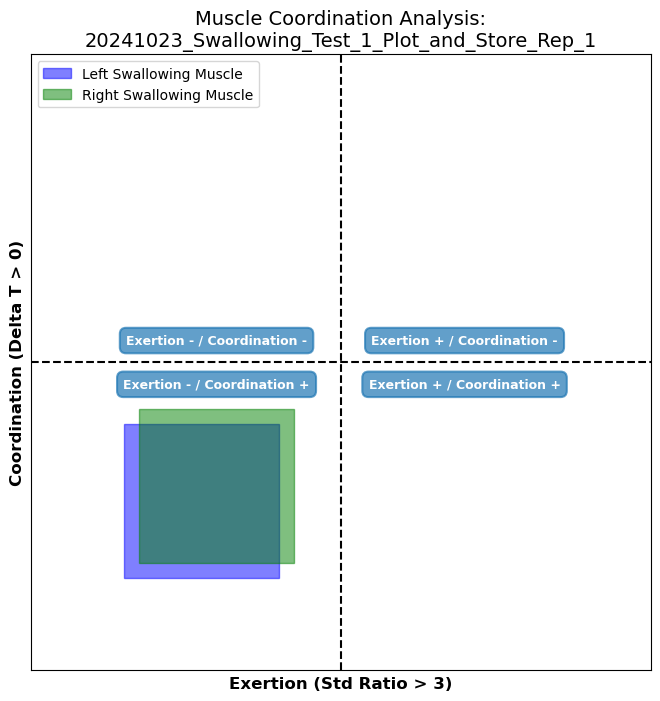

Processing file:  20241023_Swallowing_Test_2_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 0.32 s
signal LL basic Std :  0.00000118, signal RL basic Std :  0.00000465
left std ratio:  0.875951, right std ratio:  0.919516
LM_max_index:  1.518 sec, LL_max_index:  1.993 sec, left delta t: -0.476 sec
LM_max:  0.03002 (mV), LL_max:  0.00715 (mV)
RM_max_index:  9.771 sec, RL_max_index:  0.360 sec, right delta t:  9.411 sec
RM_max:  1.24635 (mV), RL_max:  0.03436 (mV)


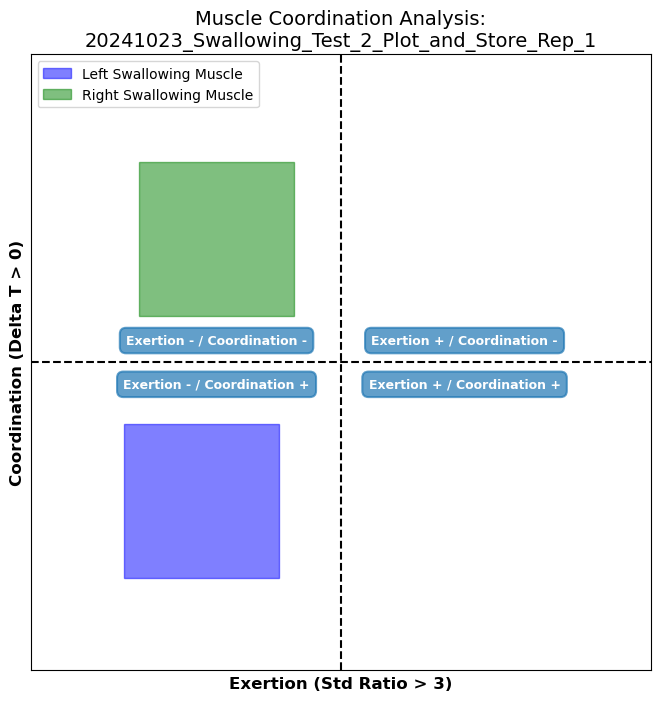

Processing file:  20241023_Swallowing_Test_3_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 7.06 s
signal LL basic Std :  0.00000105, signal RL basic Std :  0.00000178
left std ratio:  1.215238, right std ratio:  1.957101
LM_max_index:  15.019 sec, LL_max_index:  15.473 sec, left delta t: -0.453 sec
LM_max:  5.12086 (mV), LL_max:  0.00906 (mV)
RM_max_index:  13.265 sec, RL_max_index:  15.469 sec, right delta t: -2.204 sec
RM_max:  5.39390 (mV), RL_max:  0.02966 (mV)


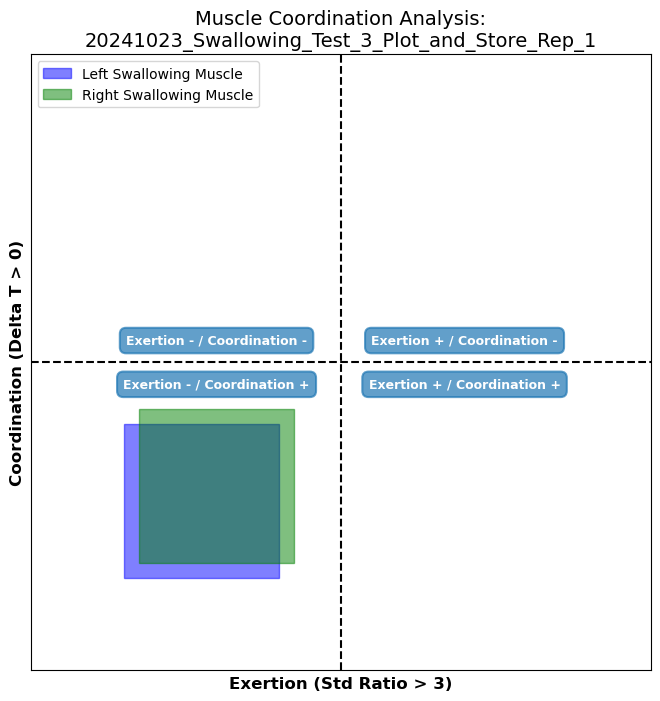

Processing file:  20241023_Swallowing_Test_4_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 3.93 s
signal LL basic Std :  0.00000102, signal RL basic Std :  0.00000198
left std ratio:  1.172435, right std ratio:  1.554233
LM_max_index:  9.278 sec, LL_max_index:  11.977 sec, left delta t: -2.698 sec
LM_max:  5.46071 (mV), LL_max:  0.00945 (mV)
RM_max_index:  7.781 sec, RL_max_index:  9.757 sec, right delta t: -1.977 sec
RM_max:  5.11691 (mV), RL_max:  0.03384 (mV)


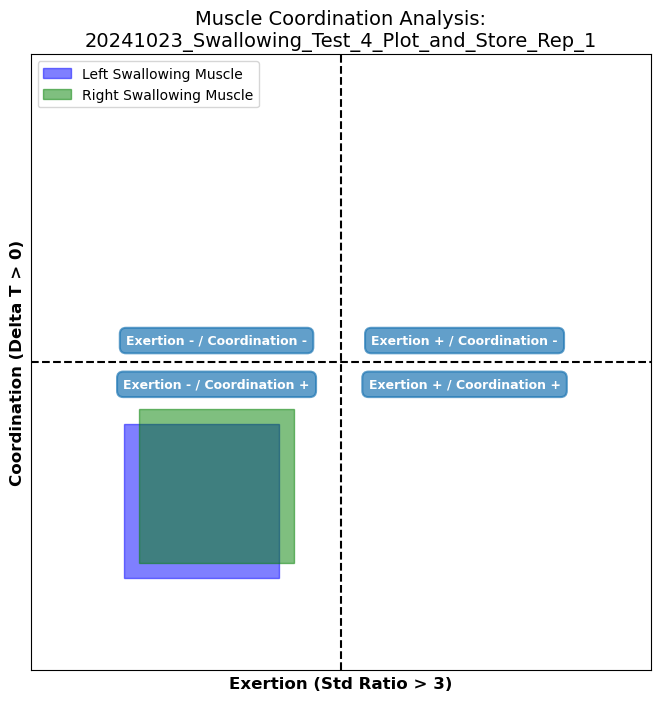

Processing file:  20241023_Swallowing_Test_5_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 3.60 s
signal LL basic Std :  0.00000112, signal RL basic Std :  0.00000203
left std ratio:  1.406369, right std ratio:  2.500174
LM_max_index:  9.787 sec, LL_max_index:  7.950 sec, left delta t:  1.838 sec
LM_max:  5.45017 (mV), LL_max:  0.01086 (mV)
RM_max_index:  12.115 sec, RL_max_index:  6.706 sec, right delta t:  5.409 sec
RM_max:  5.37563 (mV), RL_max:  0.04623 (mV)


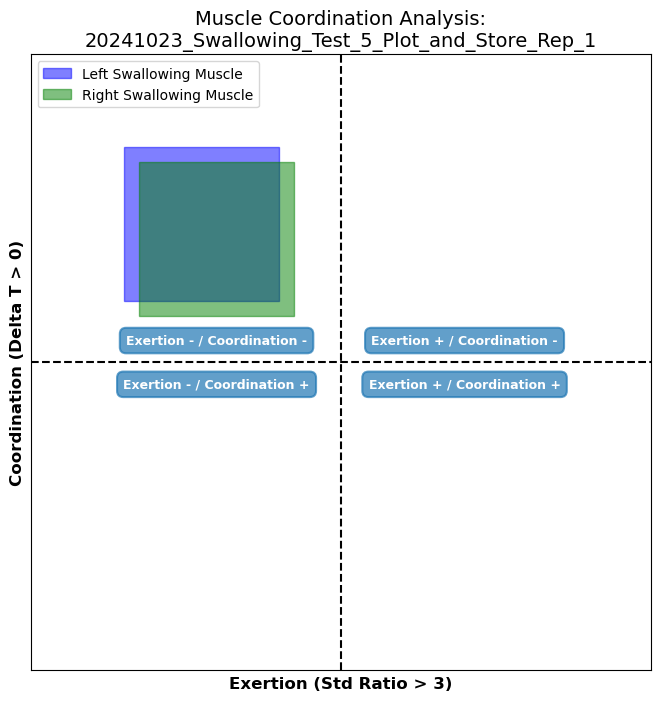

Processing file:  20241023_Swallowing_Test_6_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 2.57 s
signal LL basic Std :  0.00000112, signal RL basic Std :  0.00000199
left std ratio:  1.015824, right std ratio:  0.732338
LM_max_index:  3.119 sec, LL_max_index:  11.816 sec, left delta t: -8.696 sec
LM_max:  3.50333 (mV), LL_max:  0.00820 (mV)
RM_max_index:  5.255 sec, RL_max_index:  11.721 sec, right delta t: -6.466 sec
RM_max:  0.73842 (mV), RL_max:  0.01484 (mV)


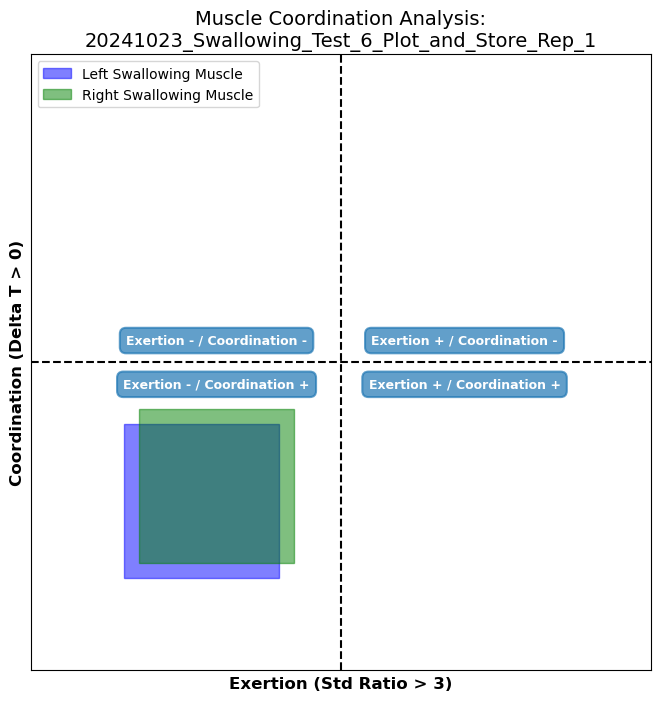

Processing file:  20241023_Swallowing_Test_7_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 4.09 s
signal LL basic Std :  0.00000125, signal RL basic Std :  0.00000297
left std ratio:  0.857287, right std ratio:  0.860954
LM_max_index:  12.439 sec, LL_max_index:  4.967 sec, left delta t:  7.472 sec
LM_max:  1.62696 (mV), LL_max:  0.00758 (mV)
RM_max_index:  8.885 sec, RL_max_index:  5.529 sec, right delta t:  3.356 sec
RM_max:  3.07404 (mV), RL_max:  0.03108 (mV)


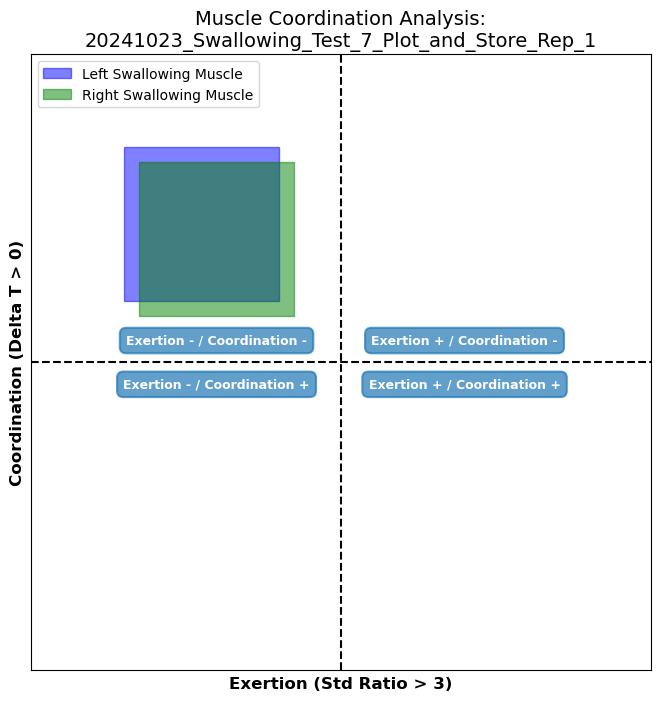

Processing file:  20241023_Swallowing_Test_8_Plot_and_Store_Rep_1
EMG 5-ACC.X Peak Time: 4.27 s
signal LL basic Std :  0.00000096, signal RL basic Std :  0.00000149
left std ratio:  1.302406, right std ratio:  1.734549
LM_max_index:  9.425 sec, LL_max_index:  12.272 sec, left delta t: -2.848 sec
LM_max:  5.46770 (mV), LL_max:  0.01199 (mV)
RM_max_index:  13.683 sec, RL_max_index:  13.026 sec, right delta t:  0.658 sec
RM_max:  1.74699 (mV), RL_max:  0.02746 (mV)


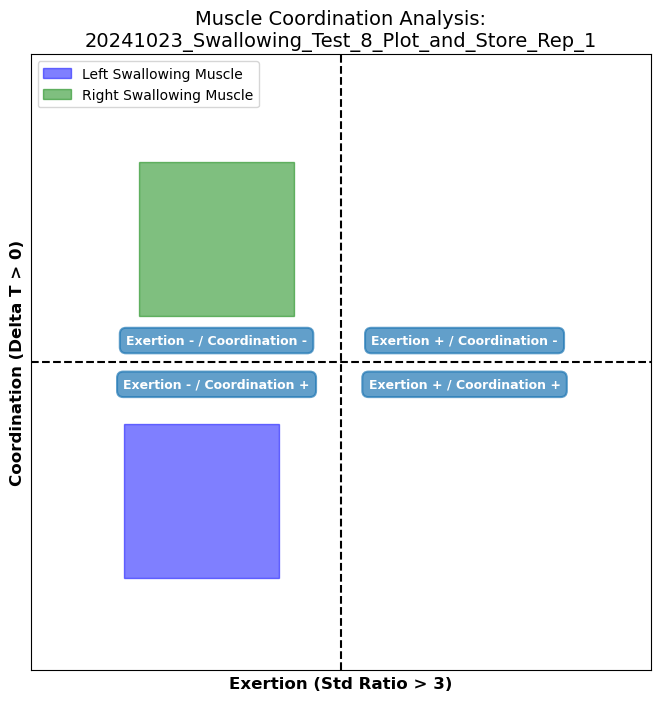

Processing file:  20241030_Swallowing_Test_10_Plot_and_Store_Rep_1


KeyError: "['Trigno sensor 5: Acc 5.X'] not in index"

In [19]:
# Analyze event data 
before_range = 5000
after_range = 12000

# iterate all the emg data
for index in range(len(csv_files)): # len(csv_files)
    
    selected_df, file_name = get_the_selected_df(index, before_range, after_range)
    signal_LL_RMS, signal_LM_RMS, signal_RL_RMS, signal_RM_RMS, signal_LL_basics_std, signal_RL_basics_std = data_preprocessing(selected_df, before_range)

    # Get event signal data with event time duration
    event_signal_LL = signal_LL_RMS.tail(after_range)
    event_signal_LM = signal_LM_RMS.tail(after_range)

    event_signal_RL = signal_RL_RMS.tail(after_range)
    event_signal_RM = signal_RM_RMS.tail(after_range)

    # Calculate std ratio with zero division check
    left_event_std = event_signal_LL.std()
    if signal_LL_basics_std != 0:
        left_std_ratio = left_event_std / signal_LL_basics_std
    else:
        left_std_ratio = float('inf')  # 或者你可以選擇其他適當的值或處理方式

    right_event_std = event_signal_RL.std()
    if signal_RL_basics_std != 0:
        right_std_ratio = right_event_std / signal_RL_basics_std
    else:
        right_std_ratio = float('inf')  # 或者你可以選擇其他適當的值或處理方式

    print(f"left std ratio: {left_std_ratio: .6f}, right std ratio: {right_std_ratio: .6f}")
    
    # Get signal max value index
    LL_max_index = selected_df.loc[event_signal_LL.idxmax(), 'time']
    LL_max = event_signal_LL.max()
    LM_max_index = selected_df.loc[event_signal_LM.idxmax(), 'time']
    LM_max = event_signal_LM.max()
    left_delta_t = LM_max_index - LL_max_index

    print(f"LM_max_index: {LM_max_index: .3f} sec, LL_max_index: {LL_max_index: .3f} sec, left delta t: {left_delta_t: .3f} sec")
    print(f"LM_max: {(LM_max * 1000): .5f} (mV), LL_max: {(LL_max * 1000): .5f} (mV)")

    RL_max_index = selected_df.loc[event_signal_RL.idxmax(), 'time']
    RL_max = event_signal_RL.max()
    RM_max_index = selected_df.loc[event_signal_RM.idxmax(), 'time']
    RM_max = event_signal_RM.max()
    right_delta_t = RM_max_index - RL_max_index
    print(f"RM_max_index: {RM_max_index: .3f} sec, RL_max_index: {RL_max_index: .3f} sec, right delta t: {right_delta_t: .3f} sec")
    print(f"RM_max: {(RM_max *1000): .5f} (mV), RL_max: {(RL_max *1000): .5f} (mV)")

    # Plot with each event data
    emg_plot(file_name, left_std_ratio, left_delta_t, right_std_ratio, right_delta_t)